# Plot3D Python Tutorial: Axial Duplication
In this tutorial you will learn how to rotate and duplicate a set of blocks by an axis then find the connectivity and periodicty of the duplicated blocks. 

Connectivity and Periodicity relates to how information is passed from one surface to another surface. 

<center><img src="https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/rotated_copied.png?raw=1" width="200"/></center>

This tutorial introduces the function `rotate_periodicity` which is different from the previous tutorial. Both codes are valid and work. 




# Environment Setup
This step is relatively short. Run the code below to install plot3d 

In [1]:
!pip install plot3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Lets download the geometry

In [2]:
!wget https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/VSPT_ASCII.xyz

--2023-02-13 22:10:04--  https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/VSPT_ASCII.xyz
Resolving nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)... 3.5.3.152, 52.217.46.44, 52.216.48.225, ...
Connecting to nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)|3.5.3.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82265056 (78M) [application/x-www-form-urlencoded]
Saving to: ‘VSPT_ASCII.xyz’

VSPT_ASCII.xyz      100%[===================>]  78.45M  15.1MB/s    in 6.5s    

2023-02-13 22:10:11 (12.1 MB/s) - ‘VSPT_ASCII.xyz’ saved [82265056/82265056]



# Reading and Writing a mesh file 
In simple words, a mesh is a collection of boxes arranged to form a shape. In this example we will explore reading a mesh in ASCII and saving it into a binary format. 




## Step 1: Load the functions from the library

In [3]:
import os, sys
from copy import deepcopy
from math import *  
import numpy as np
from plot3d import write_plot3D, read_plot3D, rotated_periodicity,connectivity_fast, rotate_block, create_rotation_matrix
import pickle

## Step 2: Read the mesh file
Code below reads the mesh file and specifies the number of blades in a full ring. The rotation angle is then calculated in degrees. 

For this example, I will be specifying 3 copies of the blocks.

In [4]:
blocks = read_plot3D("VSPT_ASCII.xyz",binary=False)  # Reading plot3D
number_of_blades = 55
rotation_angle = 360.0/number_of_blades
# Lets find the connectivity and periodicity of the rotated blocks
copies = 3 # Lets use the example with 3 copies 

## Rotate the Blocks
Blocks are rotated by the number of copies.

In [5]:
rotated_blocks = list()
rotated_blocks.extend(blocks)

for i in range(1,copies):
    # Rotation matrix can be found on https://en.wikipedia.org/wiki/Rotation_matrix
    rotation_matrix = create_rotation_matrix(radians(rotation_angle*i),"x")
    for i in range(len(blocks)):
        rotated_blocks.append(deepcopy(rotate_block(blocks[i],rotation_matrix)))

write_plot3D("finalmesh_rotated_binary.xyz",blocks=rotated_blocks,binary=True)

### Plotting the Mesh
The function below shows how we can plot an outline of the mesh 

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np 
from plot3d import Block

def plot_block_outline(block:Block,ax:axes3d):
  IMAX,JMAX,KMAX = block.X.shape
  X = block.X 
  Y = block.Y
  Z = block.Z 

  for i in [0,IMAX-1]:    # Plots curves at constant I bounds 
    for j in [0,JMAX-1]:
      x = X[i,j,:]
      y = Y[i,j,:]
      z = Z[i,j,:]
      ax.plot3D(x,y,z)
  for j in [0,JMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[:,j,k]
        y = Y[:,j,k]
        z = Z[:,j,k]
        ax.plot3D(x,y,z)
  for i in [0,IMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[i,:,k]
        y = Y[i,:,k]
        z = Z[i,:,k]
        ax.plot3D(x,y,z)


Try playing with this code to see if you can plot one block at a time. Also try changing the rotation 

we have 6 blocks


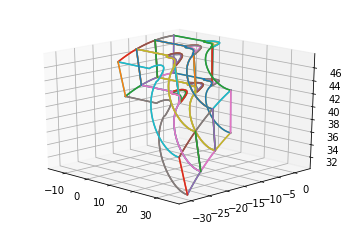

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for b in rotated_blocks:
    plot_block_outline(b,ax)
    plot_block_outline(b,ax)
ax.view_init(20,-45)

print("we have " + str(len(rotated_blocks)) + " blocks")

# Step 1: Finding Connectivity
In the above example a mesh containing 2 blocks was duplicated and rotated by a certain angle. If the copies = 55 then you would see a full annular turbine. 

**To find periodicty we must first forget about the duplication and rotation and simply find the connectivity of the 2 blocks.**


## Finding Connected Faces

The function `connectivity` takes in a parameter for blocks. The output is a list of face matches between blocks along with the outer faces which are faces that do not have a connection to another block.

To find periodicity of future sections, we need the connectivity of the **unrotated** blocks!

In [8]:
from plot3d import connectivity_fast
face_matches, outer_faces_formatted = connectivity_fast(blocks)

with open("connectivity.pickle","wb") as f:
  [m.pop("match",None) for m in face_matches] # Remove the dataframe
  pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_formatted},f)

gcd to use 4


Checking connections block 0 with 1: 100%|██████████| 1/1 [00:12<00:00, 12.38s/it]


In [9]:
import pprint
with open("connectivity.pickle","rb") as f:
  data = pickle.load(f)
  face_matches = data["face_matches"]
  outer_faces = data["outer_faces"]


face_matches
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(face_matches[0])

{   'block1': {   'IMAX': 256,
                  'IMIN': 128,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 32,
                  'KMIN': 32,
                  'block_index': 0},
    'block2': {   'IMAX': 168,
                  'IMIN': 40,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 0,
                  'KMIN': 0,
                  'block_index': 1}}


# Step 2: Find the Periodicity
Periodicity relates to how exterior faces exchange information. Take the pie example below. You can either perform simulation with the whole pie this ensures that information travels from Left to Right or you do a simulation with the slice and say what goes in or out from left also goes in or out from the right. Performing simulations on slices is faster than the whole pie. 

<center><img src="https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/periodicity.png?raw=1" width="200"/></center>

In this step we find the periodicity using a function called `rotated_periodicity`. This function scans the outer faces and rotates them by an angle. Then it checks what part of the left face matches the right face. If there are any partial matches, it splits the faces automatically.

In [10]:
# Find Neighbor Connectivity / Interblock-to-block matching
blocks = read_plot3D('VSPT_ASCII.xyz', binary = False)
periodic_faces, outer_faces_to_keep, _, _ = rotated_periodicity(blocks,face_matches, outer_faces, rotation_angle=rotation_angle, rotation_axis = "x")

Checking connections block 1 with 1: 100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


##  Find Interior Connected Faces (Inner periodicity)
Inner Periodicity or Interior Connected faces is the connected region between blocks. For example:

<center><img src="https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/inner_connectivity_pie.png?raw=1" width="200"/></center>

![Inner connectivity](https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/inner_connectivity.png?raw=1)

### Simple Example
For example, below we have a single rectangle called block 0. If we copy block 0 and place it next itself then the next rectangle is named block 1.  
 _________   _________
| block 0 | | Block 1 |

in the above image, left face of block 0 matches right face of block 0. 
When you do the copy things change a bit: the right face of block 0 matches left face of block 1 (Inner periodicity/connectivity). We also want the left face of block 0 to match right face of block 1 (Outer Periodicity)

**What we start with:**
(Left Face) Block 0 (Right Face)    

**New arrangement:**
(Left Face) Block 0 (Right Face)  (Left Face) Block 1 (Right Face)  

Here's what the data would look like in this example. 

> We start with this simple connectivity*
```json
    periodicity_with_rotate_and_copy = [
            {  
                "block 1":{
                    "Description": "This is the left face of block 0",
                    "block_index":0, "IMIN":0, "IMAX":0, "JMIN":0, "JMAX":20  
                }
            },
            {
                "block 2":{
                    "Description": "This is the right face of block 0",
                    "block_index":0, "IMIN":10, "IMAX":10, "JMIN":0, "JMAX":20
                }
            }
        ]
```

> This is the new connectivity of blocks 1 and 2

```json
    periodicity_with_rotate_and_copy = [
            {  
                "block 1":{
                    "Description": "This is the left face of block 1",
                    "block_index":1, "IMIN":0, "IMAX":0, "JMIN":0, "JMAX":20  
                }
            },
            {
                "block 2":{
                    "Description": "This is the right face of block 0",
                    "block_index":0, "IMIN":10, "IMAX":10, "JMIN":0, "JMAX":20
                }
            }
        ]
```

The code below finds the periodicity and lists the outer faces to keep. Run this first before we find the inner periodicity 

In [11]:
# Finding Periodicity between inner blocks
inner_periodicities = list()
for i in range(1,copies):
    temp = deepcopy(periodic_faces)
    for j in range(len(temp)):        
        temp[j]['block1']['block_index'] += int(i*len(blocks)) # Next set of blocks matches previous set
        temp[j]['block2']['block_index'] += int((i-1)*len(blocks)) # Right Block matches next set blocks
    inner_periodicities.extend(temp)


## Outer Periodicity
Lets go back to the simple single block rectangle example
| block 1 | block 2 | block 3|
What we are looking to do with this is to match the Left face of block 1 with the right face of block 3. Thankfully block 1 and block 3 are the same so this becomes much simplier. We simply find the periodicity of block 1 `periodic_faces` and take the right side of block 1 and increment the block number. The code below shows how this is done.

<center><img src="https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/outer_connectivity_pie.png?raw=1" width="200"/></center>

![Inner connectivity](https://github.com/nasa/Plot3D_utilities/blob/main/colab/images/outer_connectivity.png?raw=1)

In [12]:
# Add outer periodicities
outer_periodicities = deepcopy(periodic_faces)
for ou in outer_periodicities:
    ou['block2']['block_index'] += int((copies-1)*len(blocks))

## Plotting Connected Faces

In [13]:
from matplotlib import cm
import numpy as np 

def select_multi_dimensional(T:np.ndarray,dim1:tuple,dim2:tuple, dim3:tuple):
    """Takes a block (T) and selects X,Y,Z from the block given a face"s dimensions
        theres really no good way to do this in python 
    Args:
        T (np.ndarray): arbitrary array so say a full matrix containing X
        dim1 (tuple): 20,50 this selects X in the i direction from i=20 to 50
        dim2 (tuple): 40,60 this selects X in the j direction from j=40 to 60
        dim3 (tuple): 10,20 this selects X in the k direction from k=10 to 20

    Returns:
        np.ndarray: returns X or Y or Z given some range of I,J,K
    """
    if dim1[0] == dim1[1]:
        return T[ dim1[0], dim2[0]:dim2[1]+1, dim3[0]:dim3[1]+1 ]
    if dim2[0] == dim2[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0], dim3[0]:dim3[1]+1 ]
    if dim3[0] == dim3[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0]:dim2[1]+1, dim3[0] ]
    
    return T[dim1[0]:dim1[1], dim2[0]:dim2[1], dim3[0]:dim3[1]]

def plot_face(face_matches,blocks):
  for fm in face_matches:
    block_index1 = fm["block1"]["block_index"]
    I1 = [fm["block1"]["IMIN"],fm["block1"]["IMAX"]] # [ IMIN IMAX ]
    J1 = [fm["block1"]["JMIN"],fm["block1"]["JMAX"]] # [ JMIN JMAX ]
    K1 = [fm["block1"]["KMIN"],fm["block1"]["KMAX"]] # [ KMIN KMAX ]

    block_index2 = fm["block2"]["block_index"]
    I2 = [fm["block2"]["IMIN"],fm["block2"]["IMAX"]] # [ IMIN IMAX ]
    J2 = [fm["block2"]["JMIN"],fm["block2"]["JMAX"]] # [ JMIN JMAX ]
    K2 = [fm["block2"]["KMIN"],fm["block2"]["KMAX"]] # [ KMIN KMAX ]

    X1 = select_multi_dimensional(blocks[block_index1].X, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Y1 = select_multi_dimensional(blocks[block_index1].Y, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Z1 = select_multi_dimensional(blocks[block_index1].Z, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))

    X2 = select_multi_dimensional(blocks[block_index2].X, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Y2 = select_multi_dimensional(blocks[block_index2].Y, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Z2 = select_multi_dimensional(blocks[block_index2].Z, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))

    # return X1
    surf1 = ax.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    surf2 = ax.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


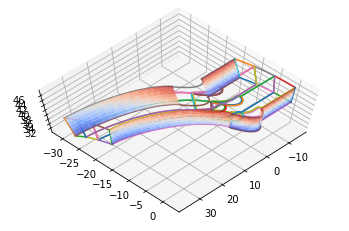

In [16]:
# Plotting the outer faces 

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for b in rotated_blocks:
  plot_block_outline(b,ax)

plot_face(outer_periodicities,rotated_blocks)

ax.view_init(70,45)

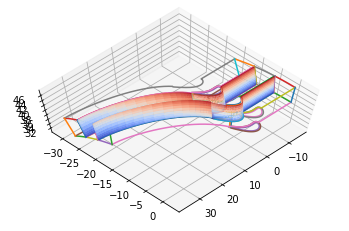

In [17]:
# Plotting Inner Connected faces
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for b in rotated_blocks:
  plot_block_outline(b,ax)

plot_face(inner_periodicities,rotated_blocks)

ax.view_init(70,45)

# Plotting using Paraview

See this [example](https://github.com/nasa/Plot3D_utilities/tree/main/python/examples/cascade_axial_duplication) 